In [1]:
# Math libraries
import numpy as np
import random
from scipy.linalg import sqrtm
from scipy.stats import multivariate_normal
from scipy.integrate import odeint
from numpy.linalg import inv

# I/O libraries
import os
import scipy.io as sio

# Graphical Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec

In [2]:
def H_linear(X):
    ''' Calculates the observation operator for linear observations.
      
      ***INPUT***:
         X : ensemble in state space (size: [# state variable in inner domain * # of ens member])
      ***OUTPUT***:
         Hx: ensemble in the observation space (size: [# of ens member])
     '''

    Hx = X;
    
    return Hx;

def H_linear_adjoint(X):
    
    ''' Subroutine for the adjoint of the observation operator (analytical solution) for "one observation"
        
        ***INPUT***
           X : ensemble in state space (size: [# state variable in inner domain * # of ens member])
        ***OUTPUT***
           dHdx: adjoint (size: [# state variable in inner domain * # of ens member])
    '''
    
    dim_inner=X.shape[0]
    n_mem=X.shape[1]
    
    dHdx=np.ones((dim_inner,n_mem))
    
    return dHdx;


In [3]:
#----------------------------------------------
#   FUNCTIONS
#----------------------------------------------

def h_operator(nx,obs_vect):
    
    #nx=len(obs_vect)
    index_obs=np.where(obs_vect>-999)[0]
    num_obs=len(index_obs)
    
    h_matrix=np.zeros((num_obs,nx))
    for i in range(num_obs):
        h_matrix[i,index_obs[i]]=1
        
    return h_matrix

In [4]:
# def L63_RK4(rho, sigma, beta, initV, tint, tstep):

In [5]:
# NOTE: There are problems in this calculation because a variable
# and a function have the same names
def grad_log_post(H,R,R_inv,y,y_i,B,x_s_i,x0_mean):
    #obs_part=(H.transpose()).dot(R_inv).dot(y-y_i)[:,0]
    obs_part=B.dot(H.transpose()).dot(R_inv).dot(y-y_i)[:,0]
    #prior_part=B_inv.dot(x_s_i-x0_mean)
    prior_part=x_s_i-x0_mean
    grad_log_post_est=obs_part-prior_part
    #return grad_log_post_est,obs_part,prior_part;
    return grad_log_post_est;

In [6]:
# Version 1

def L96_RK4(X, dt, F):
    # integrate for L96 model using RK4
    # X is the input, dt is the time resolution
    # X_out is the output

    dim = len(X)
    k1 = np.zeros(dim)
    k2 = np.zeros(dim)
    k3 = np.zeros(dim)
    k4 = np.zeros(dim)
    X_out = np.zeros(dim)

    # parameter for the model
    # F = 8;

    tmp_b = X.copy()  # before integration
    
    X_p1 = np.concatenate((tmp_b[1:], [tmp_b[0]]))
    X_00 = tmp_b
    X_n1 = np.concatenate(([tmp_b[-1]], tmp_b[:-1]))
    X_n2 = np.concatenate((tmp_b[-2:], tmp_b[:-2]))
    
    k1 = (X_p1 - X_n2) * X_n1 - X_00 + F
    
    tmp_b = X + 0.5 * k1 * dt
    X_p1 = np.concatenate((tmp_b[1:], [tmp_b[0]]))
    X_00 = tmp_b
    X_n1 = np.concatenate(([tmp_b[-1]], tmp_b[:-1]))
    X_n2 = np.concatenate((tmp_b[-2:], tmp_b[:-2]))
    
    k2 = (X_p1 - X_n2) * X_n1 - X_00 + F
    
    tmp_b = X + 0.5 * k2 * dt
    X_p1 = np.concatenate((tmp_b[1:], [tmp_b[0]]))
    X_00 = tmp_b
    X_n1 = np.concatenate(([tmp_b[-1]], tmp_b[:-1]))
    X_n2 = np.concatenate((tmp_b[-2:], tmp_b[:-2]))
    
    k3 = (X_p1 - X_n2) * X_n1 - X_00 + F
    
    tmp_b = X + k3 * dt
    X_p1 = np.concatenate((tmp_b[1:], [tmp_b[0]]))
    X_00 = tmp_b
    X_n1 = np.concatenate(([tmp_b[-1]], tmp_b[:-1]))
    X_n2 = np.concatenate((tmp_b[-2:], tmp_b[:-2]))
    
    k4 = (X_p1 - X_n2) * X_n1 - X_00 + F
    
    X_out = X + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    return X_out


In [7]:
def calc_X(X):
    # Calculate X_p1, X_00, X_n1, and X_n2
    X_p1 = np.roll(X, -1, axis=0)
    X_00 = X.copy()
    X_n1 = np.roll(X, 1, axis=0)
    X_n2 = np.roll(X, 2, axis=0)
    return X_p1, X_00, X_n1, X_n2

def L96_RK4_ensemble(X_in, dt, F):
    """
    Integrate the Lorenz 96 model using RK4 for an ensemble of n_mem members
    
    Parameters:
    -----------
    X_in: numpy.ndarray
        Input array of shape (dim, n_mem)
    dt: float
        Time resolution
    F: float
        Parameter for the model
    
    Returns:
    --------
    X_out: numpy.ndarray
        Array of shape (dim, n_mem) containing the output of the integration
    """
    dim, n_mem = X_in.shape
    k1 = np.zeros((dim, n_mem))
    k2 = np.zeros((dim, n_mem))
    k3 = np.zeros((dim, n_mem))
    k4 = np.zeros((dim, n_mem))
    X_out = np.zeros((dim, n_mem))

    tmp_b = X_in.copy()  # before integration
    
    X_p1, X_00, X_n1, X_n2 = calc_X(tmp_b)

    # Calculate k1
    k1 = (X_p1 - X_n2) * X_n1 - X_00 + F

    tmp_b2 = X_in + 0.5 * k1 * dt
    X_p1, X_00, X_n1, X_n2 = calc_X(tmp_b2)

    # Calculate k2
    k2 = (X_p1 - X_n2) * X_n1 - X_00 + F

    tmp_b3 = X_in + 0.5 * k2 * dt
    X_p1, X_00, X_n1, X_n2 = calc_X(tmp_b3)

    # Calculate k3
    k3 = (X_p1 - X_n2) * X_n1 - X_00 + F

    tmp_b4 = X_in + k3 * dt
    X_p1, X_00, X_n1, X_n2 = calc_X(tmp_b4)

    # Calculate k4
    k4 = (X_p1 - X_n2) * X_n1 - X_00 + F

    X_out = X_in + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    return X_out


In [8]:
def pff(n_mem,n_states,ensemble,obs_vect,r_obs,index_obs):
    
    B=np.cov(ensemble)
    x0_mean=np.mean(ensemble,axis=1)
    
    
    # ------------------------
    # Localization
    # ------------------------
    r_influ=2
    tmp = np.zeros((n_states, n_states))
    for i in range(1, 3*r_influ+1):
        tmp += np.diag(np.ones(n_states-i), i) + np.diag(np.ones(n_states-i), -i) + \
               np.diag(np.ones(i),n_states-i) + np.diag(np.ones(i), -(n_states-i))
        tmp *= np.exp(-i**2 / r_influ**2)
    mask = tmp + np.diag(np.ones(n_states))
    B=np.multiply(B,mask)
    #------------------------
    
    # Pseudo-time flow
    s=0
    max_s=100
    #ds=0.1
    ds=0.05*10;
    alpha=0.05*100; #Tuning parameter for the covariance of the kernel

    x_s=np.zeros((n_states,n_mem),order='F');
    x_s=ensemble.copy()

    kernel=np.zeros((n_states,n_mem,n_mem),order='F')
    dkdx=np.zeros((n_states,n_mem,n_mem),order='F')

    # Pseudoflow 
    python_pseudoflow=np.zeros((n_states,n_mem,max_s+1))
    python_pseudoflow[:,:,0]=x_s.copy()

    # Pseudo time for data assimilation
    while s < max_s:

        H    = np.zeros((n_obs, n_states));        # the ensemble in obs space 
        Hx   = np.zeros((n_obs, n_mem));           # the ensemble in obs space 
        dHdx = np.zeros((n_obs, n_states, n_mem)); # the adjoint of obs operator    

        gradient_posterior=np.zeros((n_states,n_mem))
        dpdx=np.zeros((n_states,n_mem))

        # Observation Operator
        for i in range(n_mem):

            H=h_operator(n_states,obs_vect)
            
            #x_s[:,i]=python_pseudoflow[:,i,s]
            #Hx[:,i]=np.ones((n_obs,1))[:,0] 
            #Hx[0,:]=x_s[10,:]
            #Hx[1,:]=x_s[511,:]
            Hx[:,:]=x_s[index_obs,:]
#             Hx[1,:]=x_s[1,:]
#             Hx[2,:]=x_s[2,:]

            dHdx[:,:,i]=np.ones((n_obs,n_states))

            y=np.ones((n_obs,1))
            #y[:,0]=obs_vect[:,0]
            y[:,0]=obs_vect[index_obs]

            y_i=np.ones((n_obs,1))
#             y_i[0,0]=Hx[0,i]
#             y_i[1,0]=Hx[1,i]
            y_i[:,0]=Hx[:,i]
#             y_i[1,0]=Hx[1,i]
#             y_i[2,0]=Hx[2,i]

    #         if s==0:
    #             x_s[:,i]=x0[:,i]
    #         else
            #grad_log_post[:,i]=(Hx.transpose()).dot(np.linalg.inv(R)).dot(y-y_i)-np.linalg.inv(B).dot(x_s[:,i]-x0_mean)
            dpdx[:,i]=grad_log_post(H,R,R_inv,y,y_i,B,x_s[:,i],x0_mean);
            
            # NOTE: There are problems in this calculation because a variable
            # and a function have the same names

            #print('It passed this line - check 01')

            # Kernel calculation

        B_d=np.zeros((n_states))
        for d in range(n_states):
            B_d[d]=B[d,d]

        #print(f'd={d}')

        fs=np.zeros((n_states,n_mem))
        I_f=np.zeros((n_states,n_mem)) # important to make sure grad_KL starts from zero! This was the error vs Matlab
        attractive_term=np.zeros((n_states,n_mem))
        repelling_term=np.zeros((n_states,n_mem))

        for i in range(n_mem):

            for j in range(n_mem):
                #xj=0;
    #             dpdx[:,j]=gradient_posterior[:,j];
                if j>=i:
                    kernel[:,i,j]=np.exp((-1/2)*((x_s[:,i]-x_s[:,j])**2)/(alpha*B_d[:]));
                    #dkdx[:,i,j]=((x_s[:,i]-x_s[:,j])/(alpha*B_d[:]))*kernel[:,i,j];
                    dkdx[:,i,j]=((x_s[:,i]-x_s[:,j])/(alpha))*kernel[:,i,j];
                else:
                    kernel[:,i,j]=kernel[:,j,i];
                    dkdx[:,i,j]=-dkdx[:,j,i];

                attractive_term[:,i]=(1/n_mem)*(kernel[:,i,j]*dpdx[:,j])
                repelling_term[:,i]=(1/n_mem)*(dkdx[:,i,j])

                I_f[:,i]=I_f[:,i]+attractive_term[:,i]+repelling_term[:,i];
                #I_f[:,i]=I_f[:,i]+attractive_term[:,i];


            # Update the state vector for next pseudo time step

            # Kernel evolution
    #         pff_kernel[:,:,:,s]=kernel[:,:,:]
    #         pff_dkdx[:,:,:,s]=dkdx[:,:,:]
            # Gradient posterior evolution
    #         pff_grad_log_post[:,:,s]=dpdx[:,:]
            # Gradient KL divergence evolution
    #         pff_grad_KL[:,:,s]=I_f
    #         pff_grad_KL_attractive[:,:,s]=attractive_term
    #         pff_grad_KL_repelling[:,:,s]=repelling_term

        for i in range(n_mem):
            #fs[:,i]=B.dot(I_f[:,i])
            fs[:,i]=I_f[:,i]
            x_s[:,i]=x_s[:,i]+ds*fs[:,i]
        python_pseudoflow[:,:,s+1]=x_s

        #print(f'finished with s={s}')

        s=s+1
            #python_pseudoflow[:,:,s]=x_s
    return  python_pseudoflow

In [9]:
# Test for Lorenz 96 Ensemble Forward Model 2023/03/10
# by Hamed Ali Diab-Montero
# h.a.diabmontero@tudelft.nl\

# TRUTH
F = 3.85
n_x = 24                       # size of the state vector
X_in = F*np.ones((n_x,1))      # initial condition (for steady state)
#X_in[0,0] += 0.01  # Add small perturbation to the first variable

X_in[n_x//5:n_x:n_x//5] = F+1  # perturbed IC (to generate chaotic behavior)

# Time information
warm_nt = 1000                 # number of warm-up time steps
n_t = 5000                     # number of time steps to simulate
tstep = 0.01                   # time step size

t_truth = np.zeros(warm_nt + n_t)
t_truth[0] = tstep
for t in range(warm_nt + n_t - 1):
    t_truth[t+1] = t_truth[t] + tstep

X_truth = np.zeros((n_x, warm_nt + n_t))
X_truth[:,0] = X_in[:,0]
for t in range(warm_nt + n_t - 1):
    X_truth[:,t+1] = L96_RK4(X_truth[:,t], tstep, F)

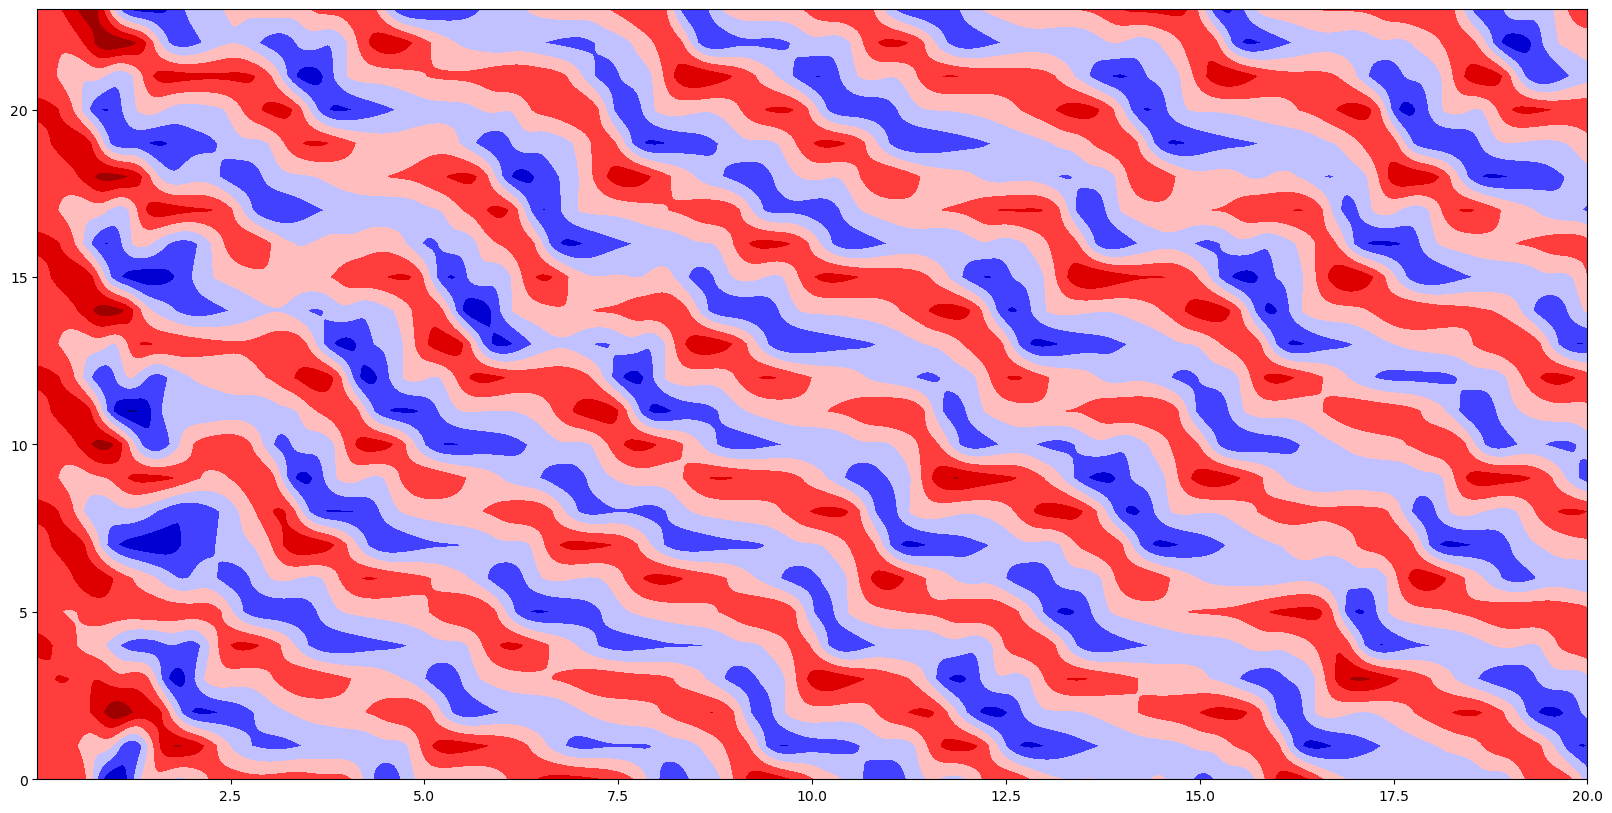

In [10]:
X_truth.shape
fig=plt.figure(figsize=(20,10))
x=t_truth
y=range(n_x)
X,Y = np.meshgrid(x,y)
#plt.pcolor(X[:,0:2000],Y[:,0:2000],X_truth[:,0:2000],cmap='seismic')
plt.contourf(X[:,0:2000],Y[:,0:2000],X_truth[:,0:2000],cmap='seismic')

In [11]:
#OBSERVATIONS
obs_rate = 50      # interval of time steps between observations
obs_den = 1        # observation density (every obs_den -th grids are observed)
t_obs = t_truth[::obs_rate]
index_truth = range(len(t_truth))


mu_pert = 0
sigma_pert = 1.5

# Dataset to test method
# x_dataset = np.loadtxt('obs_l96_40_100000.txt')

# Observations
r_eps = np.sqrt(2)
mu_pert = 0
pert_obs = np.random.normal(mu_pert, r_eps, [ len(t_obs), int(n_x/obs_den)])


# NOTE: @Hamed -->modify from here
x_obset = np.ones((len(t_obs), n_x+2)) * -999
x_obset[:, 0] = t_obs
x_obset[:,1] = index_truth[::obs_rate]
x_obset[:, 2::obs_den] = np.transpose(X_truth[::obs_den,::obs_rate]) + pert_obs

# t_first_da = 10
# n_obs = np.count_nonzero(x_obset[t_first_da, 1:] > -999)

# r_eps = 0.3

t_first_da = int(warm_nt/obs_rate)+1 # index first assimilation 
n_obs = np.sum(x_obset[t_first_da, 2:] > -999)
R=np.eye(n_obs)*r_eps
R_inv=np.linalg.inv(R)


In [12]:
t_truth.shape

(6000,)

In [13]:
t_truth[-1]

59.99999999999663

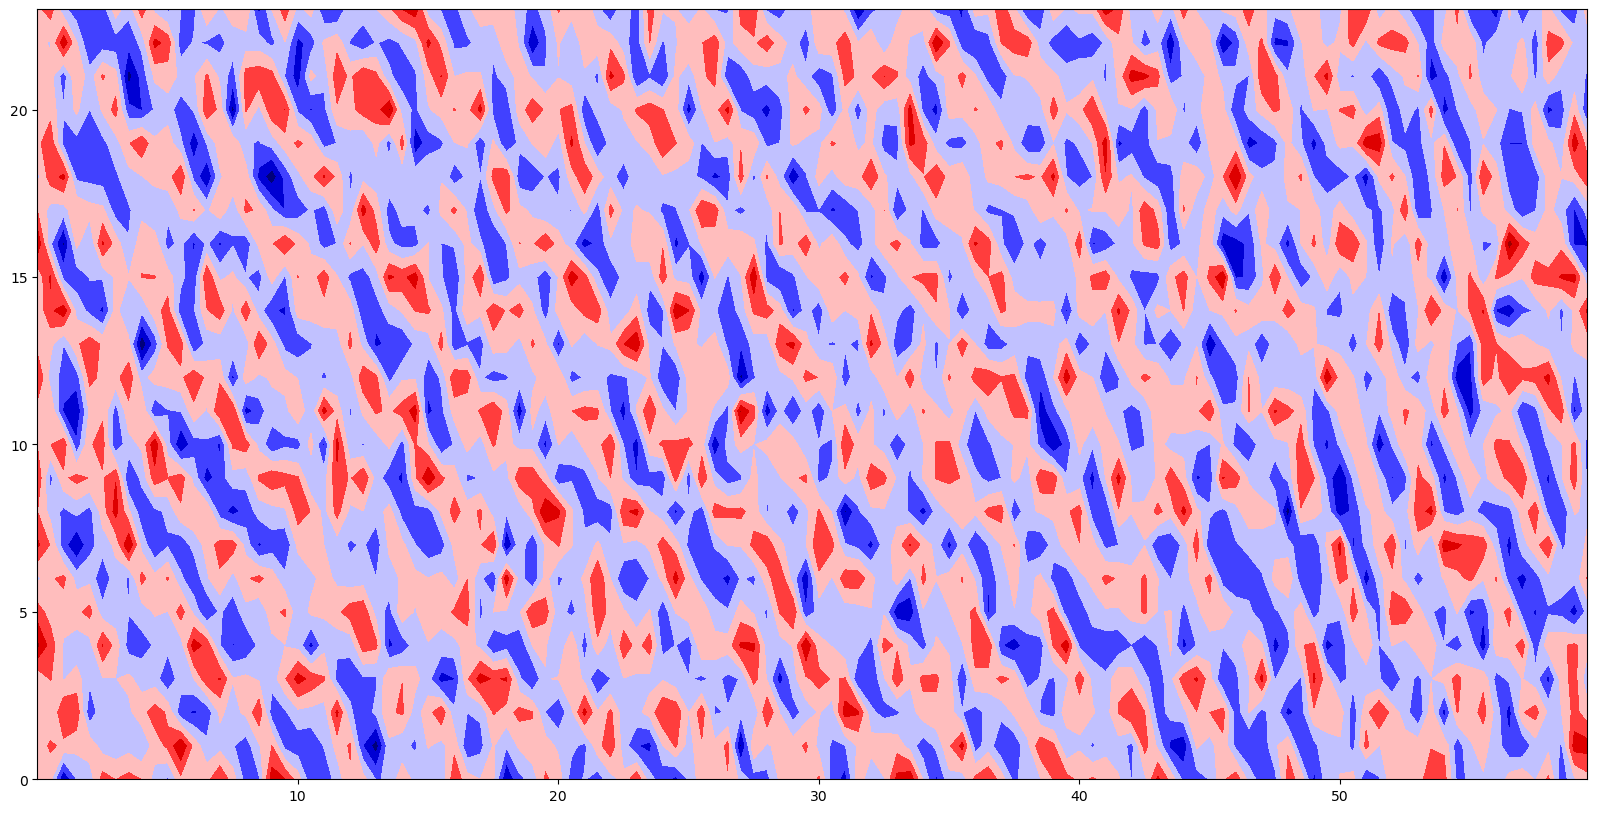

In [14]:
fig=plt.figure(figsize=(20,10))
x=t_obs
y=range(n_x)
X,Y = np.meshgrid(x,y)
#plt.pcolor(X,Y,np.transpose(x_obset[:,2:]),cmap='seismic')
plt.contourf(X,Y,np.transpose(x_obset[:,2:]),cmap='seismic')

In [15]:
#-----------------------------------------
# Particle Flow Filter
#-----------------------------------------

n_mem=100;                  # N - Ensemble size
                            # Bandwith hyperparameter5

ctlmean = X_truth[:, 0] + np.random.multivariate_normal(np.zeros(n_x), np.eye(n_x)).T

# initial condition
n_t=len(t_truth)
X_t = np.zeros((n_x, n_mem, n_t))
Q = 2 * np.eye(n_x)            # background error covariance (only for the initial perturbation)
Q_inv = np.linalg.inv(Q)
X_t[:,:,0] = np.random.multivariate_normal(ctlmean, Q, n_mem).T

X_0 = np.loadtxt('prior_l96_40_100_particles.txt')
# X_t[:,:,0] = X_0.copy()

t = warm_nt+1
# We will assimilate this number of steps
# t_assim < len(t_truth)-obs_rate 
t_assim = len(t_truth)-50

for k in range(warm_nt):
    X_t[:,:,k+1] = L96_RK4_ensemble(X_t[:,:,k], tstep, F)

max_s=70
pseudoflow_l96=[]

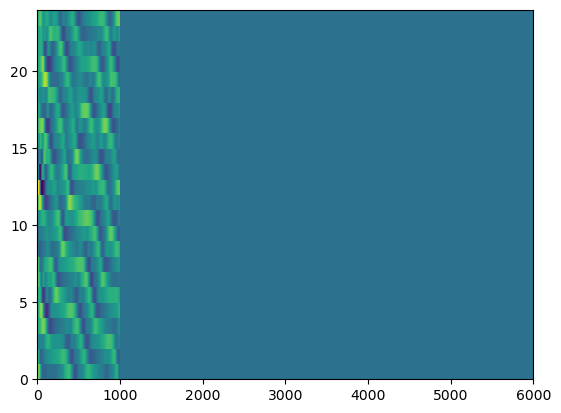

In [16]:
plt.pcolor(X_t[:,0,:])

In [17]:
d = t_first_da

# K_gain_t = np.zeros((n_x, n_x, len(t_obs)))

# n_t=len(t_truth)-warm_nt-1

# t_assim=1500 # Just for texting

while t*tstep < t_assim*tstep:
    
    t_analysis = int(np.ceil(t_obs[d]/tstep))
  
    # I need to start in k-1 beacause of the index system of python
    # We need to stop in t_analysis because of the index system of python
    for k in range(t, t_analysis,1):
        X_t[:,:,k] = L96_RK4_ensemble(X_t[:,:,k-1], tstep, F)
   
    t = t_analysis

    # Observations
    y_t = np.zeros((n_obs, 1))
    index_obs = np.where(x_obset[d, 2:] > -999)[0] # Experiment specific
    #y_t[:, 0] = x_obset[d, 2:] # Experiment specific
    y_t[:, 0] = x_obset[d, 2:][index_obs] # Experiment specific

    pseudoflow= pff(n_mem, n_x, X_t[:, :, t-1], x_obset[d, 2:], r_eps, index_obs)
    pseudoflow_l96.append(pseudoflow.copy())
     
    X_t[:, :, t-1] =  pseudoflow[:,:,-1]
 
    print(f'Finished with {int(t_analysis)}')
    
    d += 1
    
print('Finished with the estimation')

Finished with 1051
Finished with 1101
Finished with 1151
Finished with 1201
Finished with 1251
Finished with 1301
Finished with 1351
Finished with 1401
Finished with 1451
Finished with 1501
Finished with 1551
Finished with 1601
Finished with 1651
Finished with 1701
Finished with 1751
Finished with 1802
Finished with 1852
Finished with 1902
Finished with 1952
Finished with 2002
Finished with 2052
Finished with 2102
Finished with 2152
Finished with 2202
Finished with 2252
Finished with 2302
Finished with 2352
Finished with 2402
Finished with 2452
Finished with 2502
Finished with 2552
Finished with 2602
Finished with 2652
Finished with 2702
Finished with 2752
Finished with 2802
Finished with 2852
Finished with 2902
Finished with 2952
Finished with 3002
Finished with 3052
Finished with 3102
Finished with 3152
Finished with 3202
Finished with 3252
Finished with 3302
Finished with 3352
Finished with 3402
Finished with 3452
Finished with 3502
Finished with 3552
Finished with 3602
Finished wit

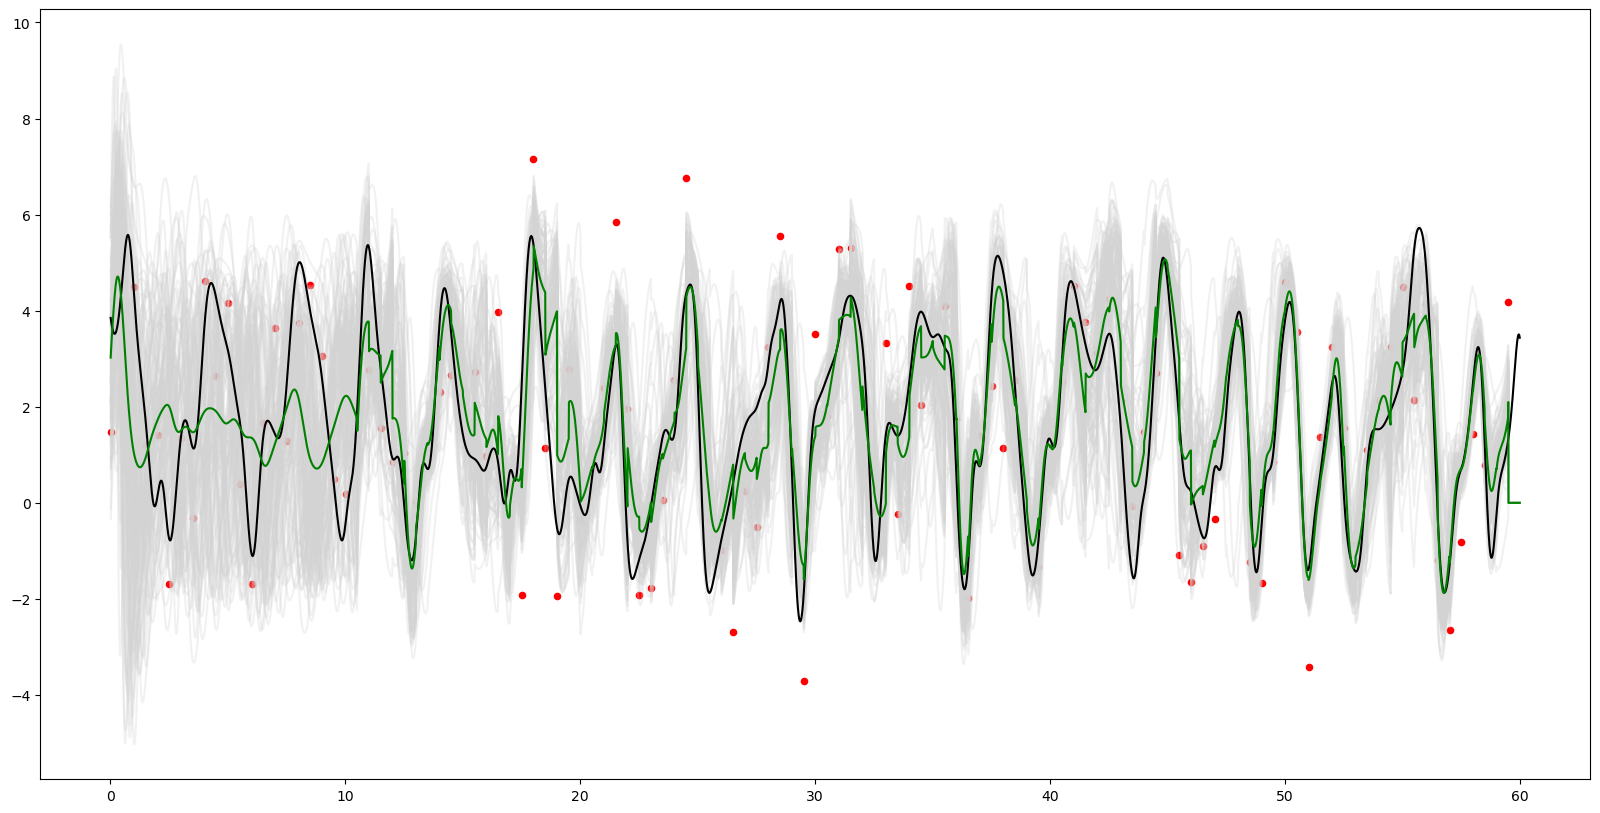

In [18]:
index_variable=6
fig=plt.figure(figsize=(20,10))
for i in range(n_mem):
    plt.plot(t_truth,X_t[index_variable,i,:],color='lightgray',alpha=0.3)
plt.plot(t_truth,X_truth[index_variable,:],color='k')
plt.plot(t_truth,np.mean(X_t[index_variable,:,:],axis=0),color='g')
plt.scatter(t_obs,x_obset[:,index_variable+2],color='r',s=20)
# plt.xlim(0,1000)

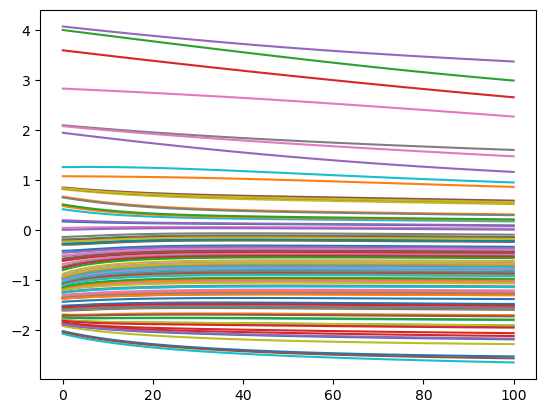

In [19]:
for i in range(n_mem):
    plt.plot(pseudoflow_l96[60][4,i,:])

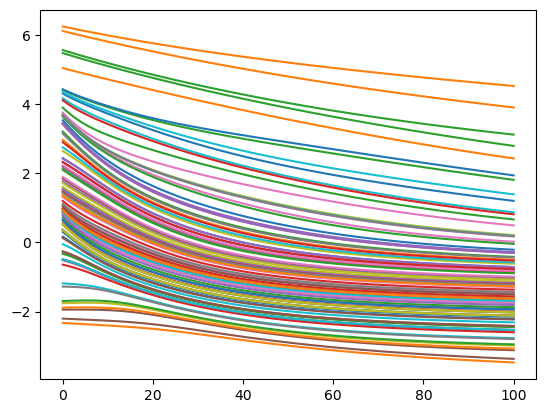

In [20]:
for i in range(n_mem):
    plt.plot(pseudoflow_l96[0][4,i,:])

# RMSE

In [ ]:
#
#  RMSE CALCULATION
#

X_t_mean=np.mean(X_t,axis=1)
print(X_t_mean.shape)

error_x_t=np.zeros((n_x,len(t_truth)))
for i in range(n_x):
    error_x_t[i,:]=(X_t_mean[i,:]-X_truth[i,:])**2
    
rmse_x_t=np.sqrt((1/n_x)*np.sum(error_x_t,axis=0))

In [ ]:
fig=plt.figure(figsize=(20,10))
plt.plot(t_truth,rmse_x_t)
plt.vlines(x=10,ymin=0,ymax=1,label='start data assimilation',color='r')
plt.xlim(10,59)
plt.xlabel('Time',fontsize=20,fontweight='bold')
plt.ylabel('RMSE',fontsize=20,fontweight='bold')

In [ ]:
# SAVE FILES
n_run_exp='01'

filename='./results_rmse/rmse_l96_periodic_obs_den_01_run_'+n_run_exp+'.txt'
results_rmse=np.zeros((len(t_truth),2))
results_rmse[:,0]=t_truth[:]
results_rmse[:,1]=rmse_x_t[:]

np.savetxt(filename,results_rmse)

In [24]:
time_slice=0
index_variable=10
sns.histplot(pseudoflow_l96[time_slice][index_variable,:,0],color='b',alpha=0.3)
sns.histplot(pseudoflow_l96[time_slice][index_variable,:,-1],color='g',alpha=0.3)
plt.vlines(x=x_obset[time_slice,2+index_variable],ymin=0,ymax=25,color='r')
plt.vlines(x=X_truth[index_variable,time_slice*int(obs_rate)],ymin=0,ymax=25,color='k')

IndexError: index 10 is out of bounds for axis 0 with size 10

In [32]:
pseudoflow_l96[10][6,i,0]

-3.423845776624758

In [33]:
x_obset[10,6]

-0.7308987409297143

In [34]:
x_obset.shape

(120, 42)

In [35]:
X_truth.shape

(40, 6000)

In [36]:
1500*tstep

15.0

In [37]:
x_obset

array([[ 1.00000000e-02,  0.00000000e+00,  7.76400606e+00, ...,
        -9.99000000e+02,  9.25049395e+00, -9.99000000e+02],
       [ 5.10000000e-01,  5.00000000e+01,  5.07953433e+00, ...,
        -9.99000000e+02,  4.53377259e+00, -9.99000000e+02],
       [ 1.01000000e+00,  1.00000000e+02,  5.12830514e+00, ...,
        -9.99000000e+02,  7.60497961e+00, -9.99000000e+02],
       ...,
       [ 5.85100000e+01,  5.85000000e+03,  1.19988643e+01, ...,
        -9.99000000e+02,  5.24471531e-01, -9.99000000e+02],
       [ 5.90100000e+01,  5.90000000e+03,  2.81086191e-01, ...,
        -9.99000000e+02,  7.51474256e+00, -9.99000000e+02],
       [ 5.95100000e+01,  5.95000000e+03,  2.53757566e+00, ...,
        -9.99000000e+02, -3.52987311e+00, -9.99000000e+02]])